In [1]:
import os, sys
import re
import numpy as np
import imageio.v2 as im
import pandas as pd
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
from cv2 import imwrite
from IPython.core.display import HTML
from scipy.interpolate import splprep
from scipy.interpolate import splev
from tools import skeleton_to_centerline
from cellpose import utils
from scipy.signal import find_peaks
from scipy.signal import argrelmax
from tools import bool_sort
from fil_finder import FilFinder2D, Filament2D
from fil_finder.tests.testing_utils import generate_filament_model
from astropy.io import fits
import astropy.units as u
import tools 
from skimage.util import invert
from imageio.v2 import imwrite
import sknw
from networkx import shortest_path

cell_path = "Individual_cells/"

In [2]:
all_the_cells = os.listdir(cell_path)

# List of masks with associated timepoints and names
maskl = []
#list of skeletons (before and after branch pruning) with associated timepoints
unpruned_skell=[]
skell = []
#list of outlines with associated metadata
outlines=[]
#list of splines with associated metadata, poles and centroids
splines=[]
#overwrite skeleton_check
for cell in all_the_cells:
    time = re.findall(r'\d+', cell)
    if time != []:
        time = time[0]
        im_path = cell_path + cell + '/masks'
        #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
        for mask_name in os.listdir(im_path):
            if mask_name[len(mask_name)-3:len(mask_name)]!='png':
                continue
            ID = int(mask_name[5:6])
            time = int(time)
            mask=im.imread(im_path+'/'+mask_name) #the cells mask (opencv image)
            unpruned_skel, skel = tools.fskel(mask)
            mask = mask[:,:,0]>0 #turn mask into a boolean array
            out = utils.masks_to_outlines(mask)
            top = np.shape(out)[0]<np.shape(out)[1]
            outline = tools.skeleton_to_centerline(np.array(out),top)
            outline = outline + [outline[0]]
            tck,u=splprep(np.transpose(outline),per=1)
            [ys,xs]=splev(u,tck)
            long = top
            poles,centroid = tools.explore_poles(xs,ys,long)
            splines.append([np.transpose([xs,ys]),int(time),int(ID),poles,centroid,u])
            outlines.append([out,time,ID,outline])
            maskl.append([mask,time,ID])
            unpruned_skell.append([unpruned_skel,time,int(mask_name[5:6])])

/home/WereSalmon/miniconda3/envs/cellpose/lib/python3.8/site-packages/fil_finder/filfinder2D.py:142: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
/home/WereSalmon/miniconda3/envs/cellpose/lib/python3.8/site-packages/fil_finder/filfinder2D.py:296: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
/home/WereSalmon/miniconda3/envs/cellpose/lib/python3.8/site-packages/fil_finder/filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


# 1. Take the skeleton and outline of the mask

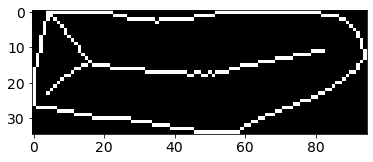

In [3]:
n = 20
skel = np.array (unpruned_skell[n][0])
outline = np.array(outlines[n][0])
plt.imshow(skel + outline, cmap=plt.cm.gray)

# 2. Fit a spline to the outline

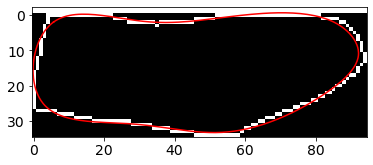

In [4]:
out = np.array(outline)
outline_periodic = skeleton_to_centerline(np.array(out),top)
outline_periodic = outline_periodic + [outline_periodic[0]]
tck,u=splprep(np.transpose(outline_periodic),per=1)
[ys,xs]=splev(u,tck)
plt.imshow(outline,cmap=plt.cm.gray)
plt.plot(xs,ys,'r-')

# 3. Extract the poles of the cell

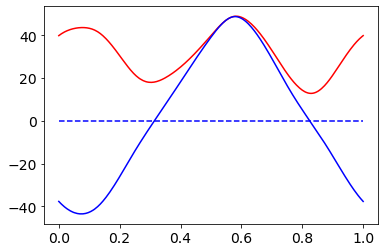

In [5]:
r,centroid = tools.radii(xs,ys)
plt.plot(u,r,'r-')
plt.plot(u,xs-centroid[0],'b-')
plt.plot(u,np.zeros(len(u)),'b--')

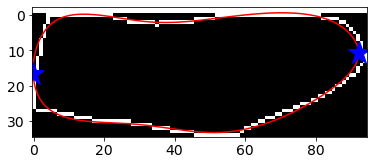

In [6]:
[pole1,pole2],centroid=tools.explore_poles(xs,ys)
plt.imshow(outline,cmap=plt.cm.gray)
plt.plot(xs,ys,'r-')
plt.plot(pole1[0],pole1[1],'b*',markersize=24)
plt.plot(pole2[0],pole2[1],'b*',markersize=24)

# 4. Compare these poles with the skeleton

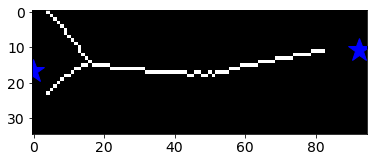

In [7]:
plt.imshow(skel,cmap=plt.cm.gray)
plt.plot(pole1[0],pole1[1],'b*',markersize=24)
plt.plot(pole2[0],pole2[1],'b*',markersize=24)

# 5. Choose the path with the least curvature and extend it to the poles

In [8]:
centerline,([xs,ys],u) = tools.prune2(skel,outline,[pole1,pole2])

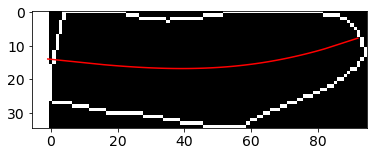

In [9]:
plt.imshow(outline,cmap=plt.cm.gray)
plt.plot(xs,ys,'r-')